In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

DATA_PATHS = {
    # "Qwen-fp8-fp8": "qwen25-7B_fp8_fp8.jsonl",
    # "Qwen-fp8-fp16": "qwen25-7B_fp8_fp16.jsonl",
    "Alpaca-fp8-fp16": "alpaca-qwen25-7B_fp8_fp16.jsonl",
    "Alpaca-fp16-fp16": "alpaca-qwen25-7B_fp16_fp16.jsonl",
    "Alpaca-fp8-fp8-diff-machines": 'alpaca-qwen25-7B_fp8_fp8-diff-machines.jsonl',
    "Alpaca-fp8-fp8-diff-machines-1": 'alpaca-qwen25-7B_fp8_fp8-diff-machines-1.jsonl',
    "Alpaca-fp16-fp16-diff-machines": 'alpaca-qwen25-7B_fp16_fp16-diff-machines.jsonl',
    "Alpaca-fp8-fp8-same3090": 'alpaca-qwen25-7B_fp8_fp8-same3090.jsonl',
    "Alpaca-fp8-fp8-sameL40": 'alpaca-qwen25-7B_fp8_fp8-sameL40.jsonl',
    "Alpaca-w8a16-w8a16-diff-machines": 'alpaca-qwen25-7B_w8a16_w8a16-diff-machines.jsonl',
    "Alpaca-w8a8-w8a16-diff-machines": 'alpaca-qwen25-7B_w8a8_w8a16-diff-machines.jsonl',
    "Alpaca-w8a8-w8a16-instruct-diff-machines": 'alpaca-qwen25-7B_w8a8_w8a16-instruct-diff-machines.jsonl',
    "Alpaca-w8a8-w8a8-instruct-same-machines-L40": 'alpaca-qwen25-7B_w8a8_w8a8-instruct-same-machines.jsonl',
    "Alpaca-w8a16-w8a16-vs-7b-w8a16": 'alpaca-qwen25-3b-w8a16-vs-7b-w8a16.jsonl',
    'Alpaca-w8a16-vs-w8a16-same-3090': 'alpaca-qwen25-w8a16-vs-w8a16-same-3090.jsonl',
    'Alpaca-w8a16-vs-w8a16-same-l40': 'alpaca-qwen25-w8a16-vs-w8a16-same-l40.jsonl',
}

from validation.data import (
    load_from_jsonl,
)

from validation.utils import distance, token_distance2, distance2, get_metric_from_result
from validation import stats


from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [50]:
import matplotlib.pyplot as plt


def process_data(items):
    distances = [
        distance2(item.inference_result, item.validation_result)
        for item in items
    ]


    top_k_matches_ratios = [d[1] for d in distances]
    distances = [d[0] for d in distances]


    def clean_data(items, distances, top_k_matches_ratios):
        """
        Fix case when tokens sequences don't match
        """
        original_len = len(items)
        drop_items = []
        for item, d in zip(items, distances):
            if d == -1:
                drop_items.append(item)
            
        items = [item for item in items if item not in drop_items]
        distances = [distance for distance in distances if distance != -1]
        top_k_matches_ratios = [ratio for ratio in top_k_matches_ratios if ratio != -1]
        print(f"Dropped {len(drop_items)} / {original_len} items")

        return items, distances, top_k_matches_ratios


    items, distances, top_k_matches_ratios = clean_data(items, distances, top_k_matches_ratios)
    return items, distances, top_k_matches_ratios



def analyze(distances, top_k_matches_ratios):
    stats.describe_data(distances, name="distances")
    stats.describe_data(top_k_matches_ratios, name="top_k_matches_ratios")
    best_fit, fit_results = stats.select_best_fit(distances)
    stats.plot_real_vs_fitted(distances, dist_name=best_fit.dist_name, bins=250)

    return best_fit, fit_results



def plot_distances_and_matches(items, distances, top_k_matches_ratios, title_prefix=""):
    """
    Plots two scatter plots side by side:
      1) Distances vs. # of tokens
      2) Top-K Matches Ratios vs. # of tokens
    """
    n_tokens = [len(item.inference_result.results) for item in items]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(n_tokens, distances, alpha=0.3)
    plt.xlabel("Number of tokens")
    plt.ylabel("Distance")
    plt.title(f"{title_prefix} Distance vs. #tokens")

    plt.subplot(1, 2, 2)
    plt.hist(distances, bins=50, alpha=0.7, color="orange", edgecolor='black')
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.title(f"{title_prefix} Distance Distribution")
    
    plt.tight_layout()
    plt.show()


In [51]:
import matplotlib.pyplot as plt


def plot_probability_distribution(items):
    inf_dist = []
    val_dist = []
    for item in items[:100000]:
        inf_metric = get_metric_from_result(item.inference_result)
        val_metric = get_metric_from_result(item.validation_result)
        # print(f"{inf_metric:.4f} {val_metric:.4f}")

        inf_dist.append(inf_metric)
        val_dist.append(val_metric)

    plt.hist(inf_dist, bins=100, alpha=0.5, label='Inference')
    plt.hist(val_dist, bins=100, alpha=0.5, label='Validation')
    plt.legend()
    plt.show()




################################################################################
Analyzing Alpaca-fp8-fp16 : alpaca-qwen25-7B_fp8_fp16.jsonl
Dropped 0 / 2900 items


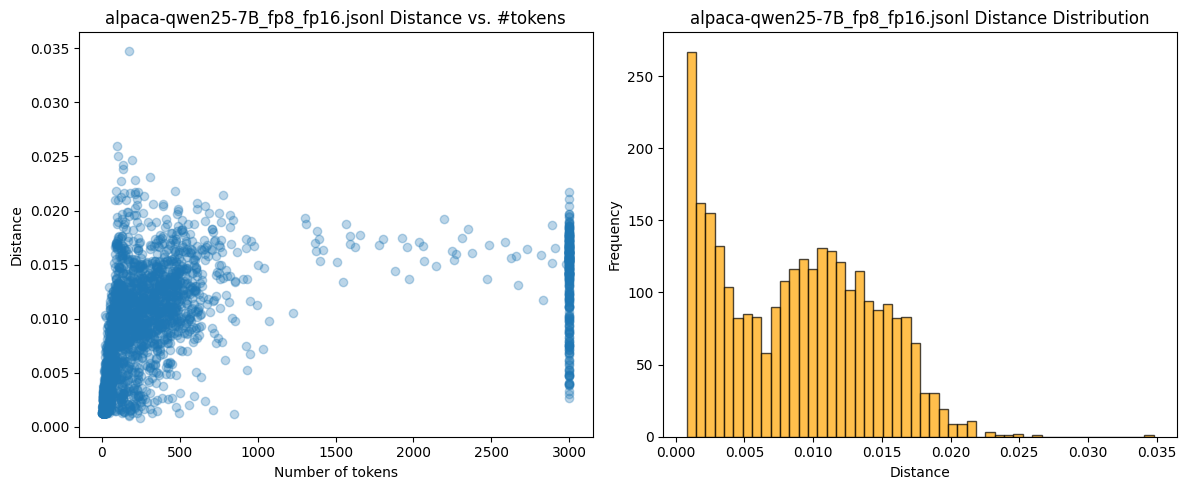

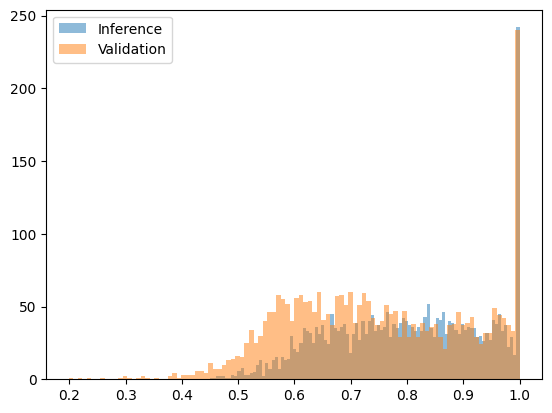


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 2900
Min:   0.0008
Max:   0.0348
Mean:  0.0088
Std:   0.0054
Quartiles:
0.25    0.003582
0.50    0.008972
0.75    0.013106
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 2900
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0088, sigma=0.0054
KS test: statistic=0.0893, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=1.9524, loc=0.0000, scale=0.0045
KS test: statistic=0.1080, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.8403, loc=0.0000, scale=0.0067
KS test: statistic=0.1454, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=1.9415, beta=217.6331, loc=0.0000, scale=1.0000
KS test: statistic=0.1074, p-value=0.0000
###################################################################

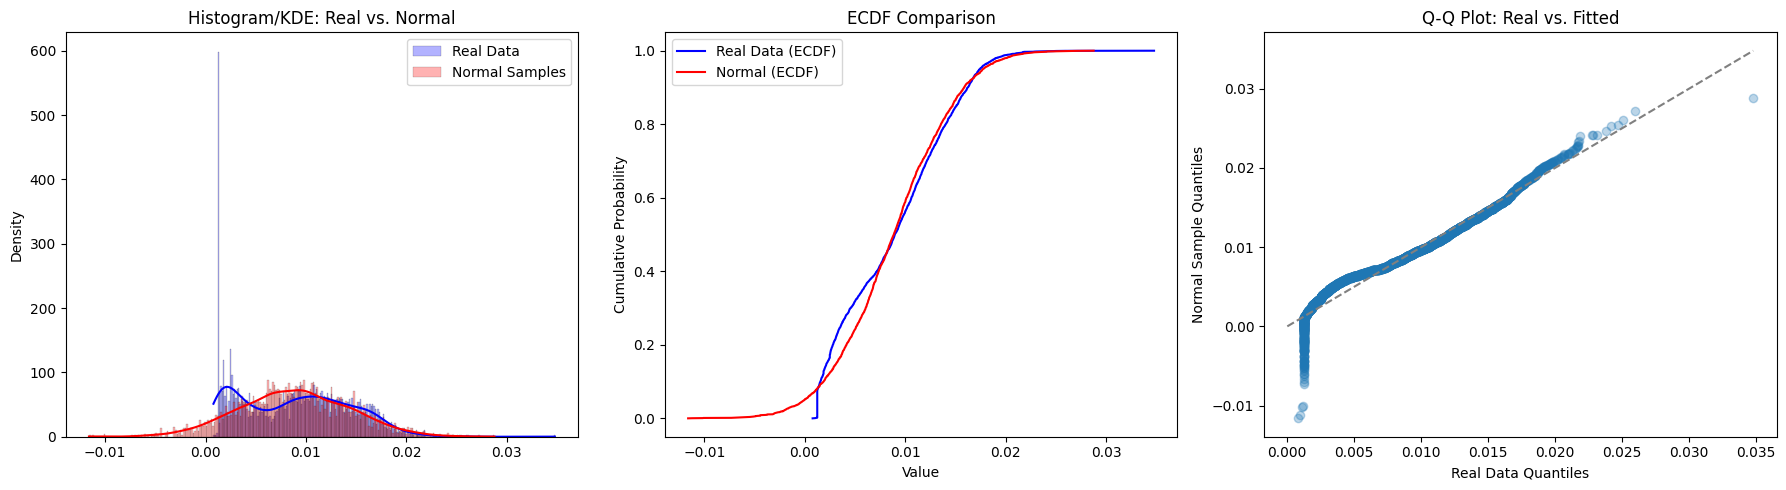




################################################################################
Analyzing Alpaca-fp16-fp16 : alpaca-qwen25-7B_fp16_fp16.jsonl
Dropped 0 / 2300 items


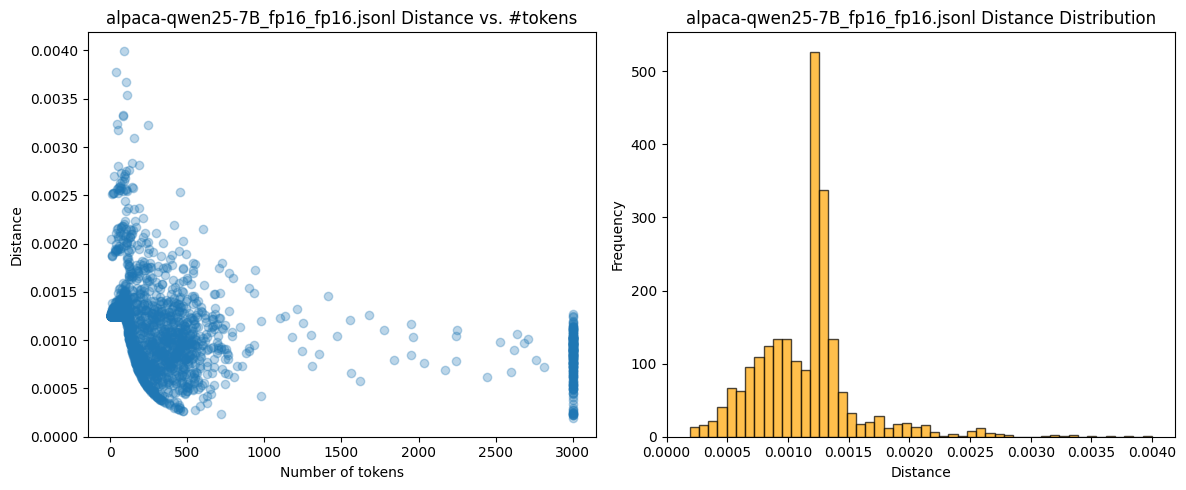

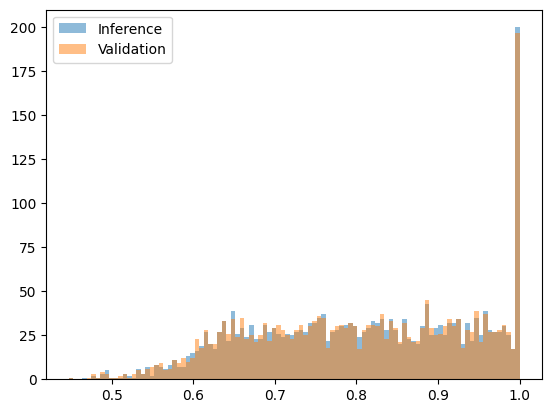


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 2300
Min:   0.0002
Max:   0.0040
Mean:  0.0012
Std:   0.0004
Quartiles:
0.25    0.000891
0.50    0.001248
0.75    0.001285
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 2300
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0012, sigma=0.0004
KS test: statistic=0.1558, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=7.6461, loc=0.0000, scale=0.0002
KS test: statistic=0.1617, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.3811, loc=0.0000, scale=0.0011
KS test: statistic=0.1770, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=7.6376, beta=6617.9170, loc=0.0000, scale=1.0000
KS test: statistic=0.1617, p-value=0.0000
##################################################################

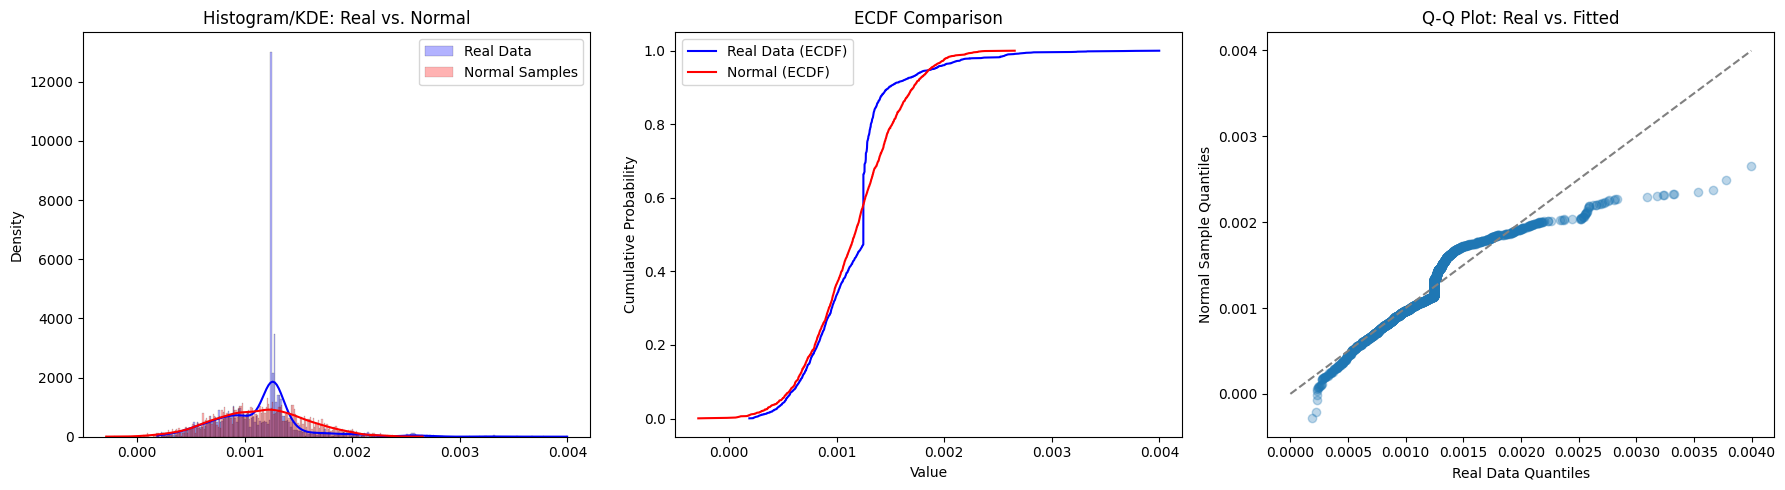




################################################################################
Analyzing Alpaca-fp8-fp8-diff-machines : alpaca-qwen25-7B_fp8_fp8-diff-machines.jsonl
Dropped 0 / 500 items


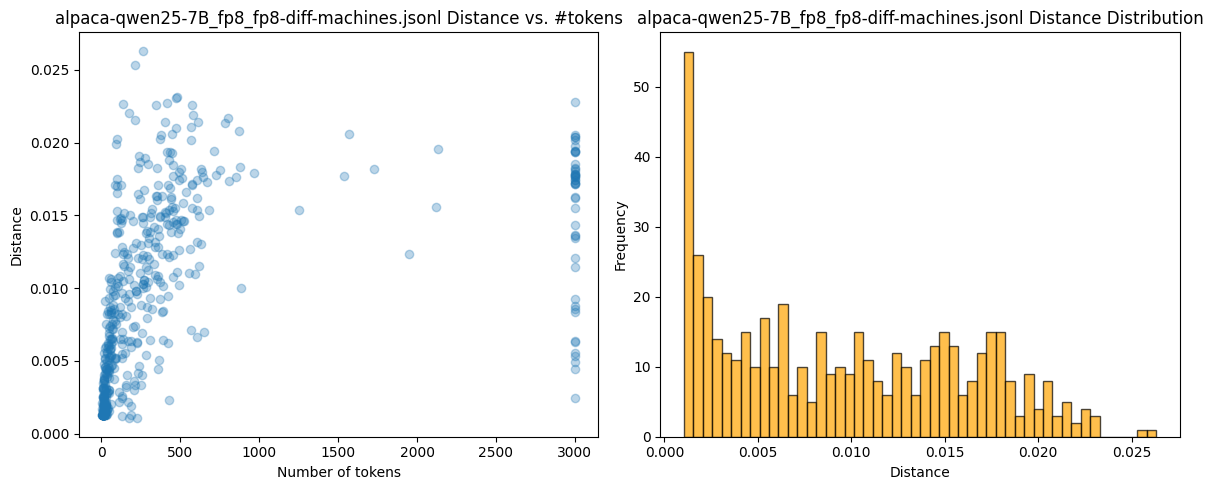

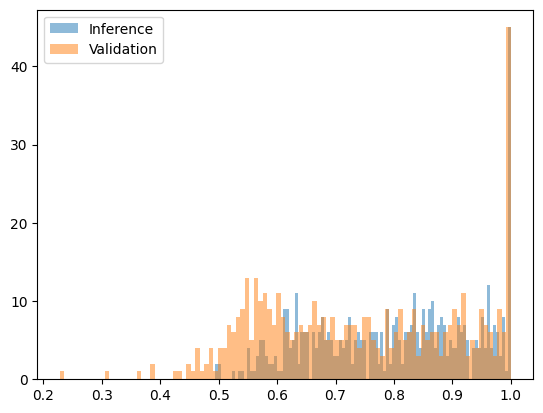


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 500
Min:   0.0010
Max:   0.0263
Mean:  0.0096
Std:   0.0064
Quartiles:
0.25    0.003479
0.50    0.008814
0.75    0.014945
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 500
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0096, sigma=0.0064
KS test: statistic=0.0981, p-value=0.0001
Fitting gamma...
Fitted Gamma Params: shape=1.6687, loc=0.0000, scale=0.0057
KS test: statistic=0.0964, p-value=0.0002
Fitting lognorm...
Fitted Lognormal Params: shape=0.9106, loc=0.0000, scale=0.0069
KS test: statistic=0.1212, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=1.6586, beta=171.6633, loc=0.0000, scale=1.0000
KS test: statistic=0.0959, p-value=0.0002
#####################################################################

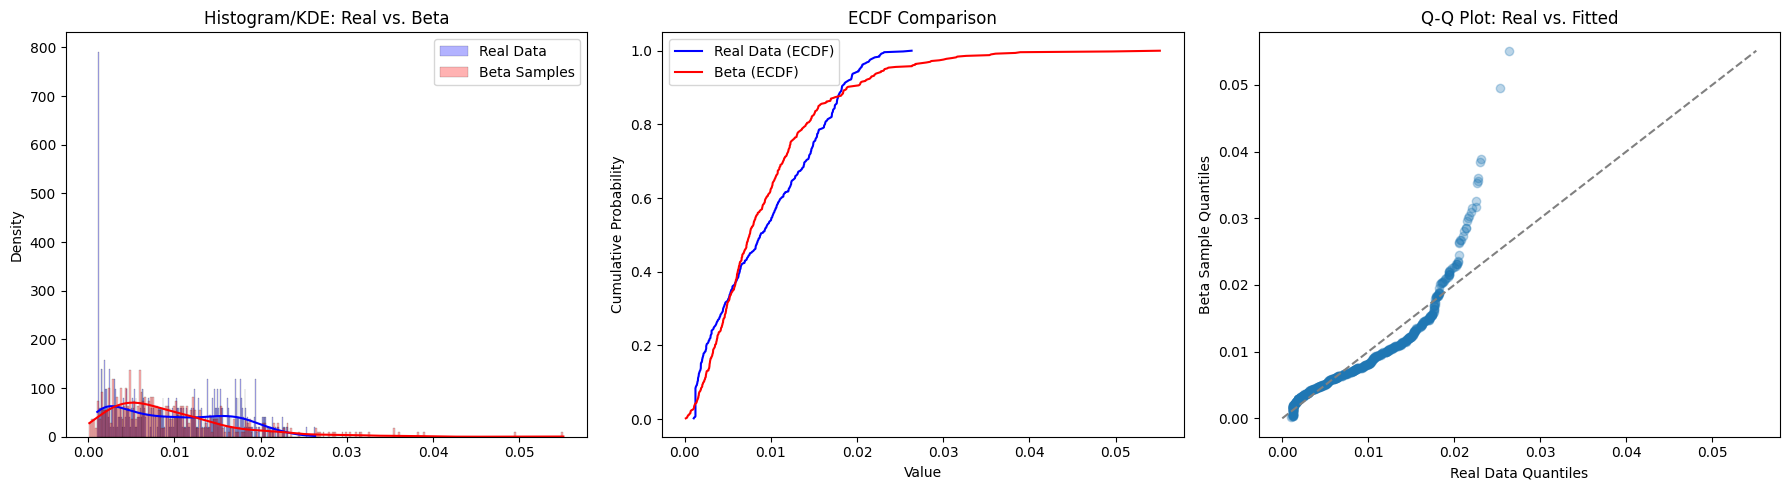




################################################################################
Analyzing Alpaca-fp8-fp8-diff-machines-1 : alpaca-qwen25-7B_fp8_fp8-diff-machines-1.jsonl
Dropped 0 / 900 items


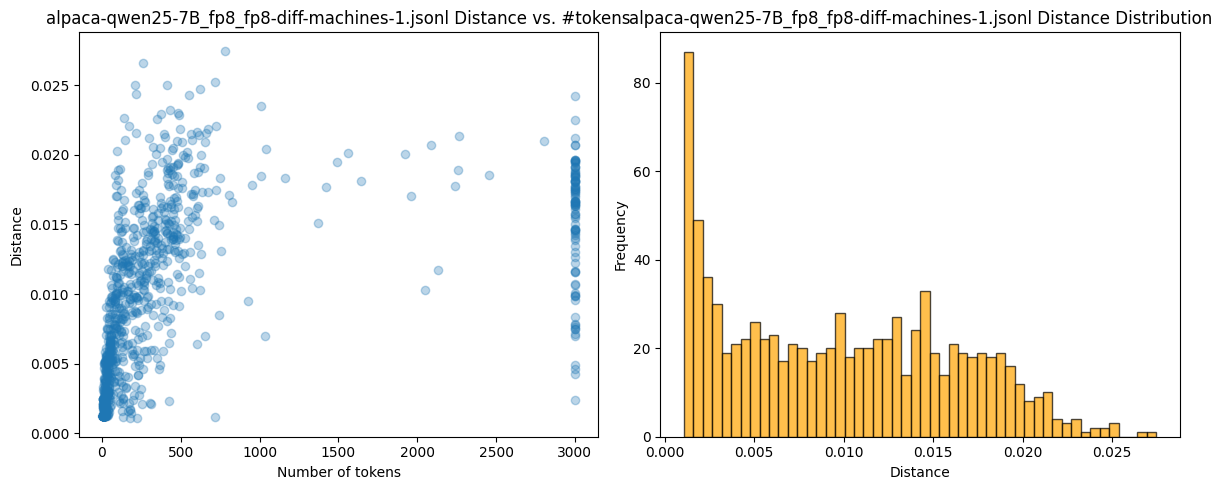

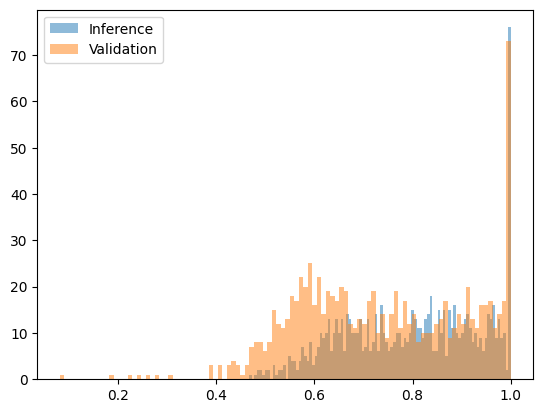


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 900
Min:   0.0011
Max:   0.0275
Mean:  0.0098
Std:   0.0064
Quartiles:
0.25    0.003781
0.50    0.009522
0.75    0.014747
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 900
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0098, sigma=0.0064
KS test: statistic=0.0871, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=1.7584, loc=0.0000, scale=0.0056
KS test: statistic=0.0971, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.8888, loc=0.0000, scale=0.0072
KS test: statistic=0.1296, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=1.7475, beta=176.8705, loc=0.0000, scale=1.0000
KS test: statistic=0.0966, p-value=0.0000
#####################################################################

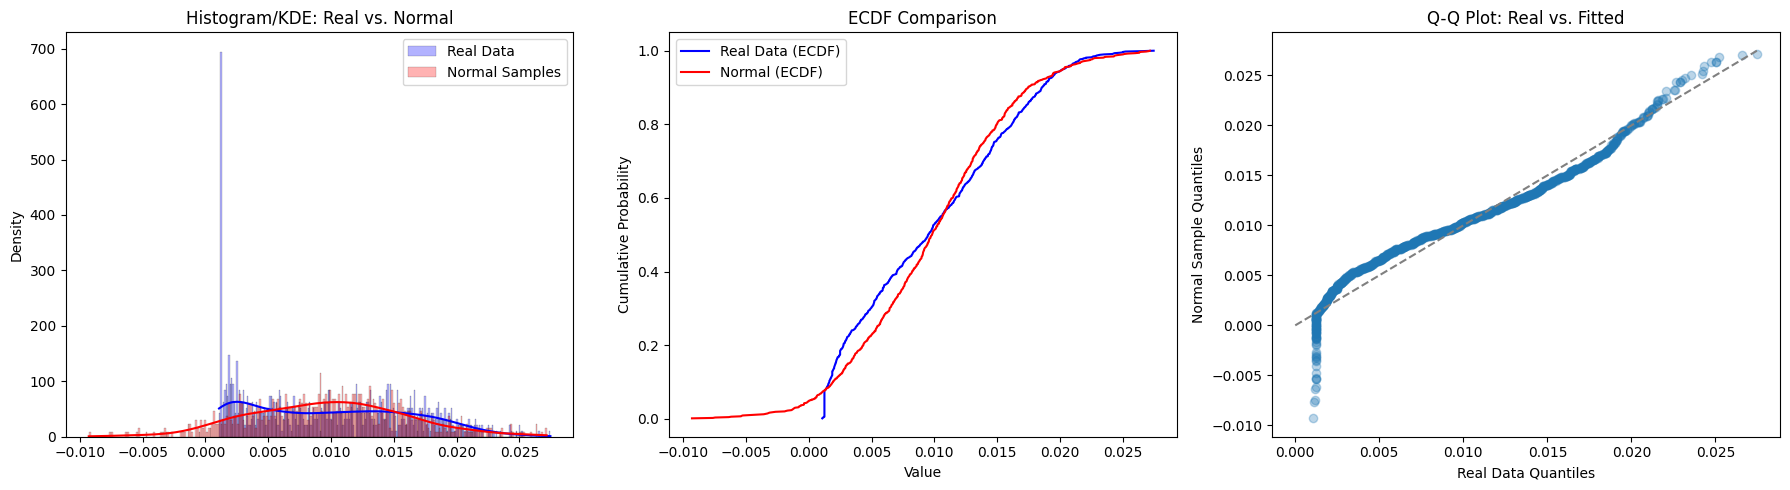




################################################################################
Analyzing Alpaca-fp16-fp16-diff-machines : alpaca-qwen25-7B_fp16_fp16-diff-machines.jsonl
Dropped 0 / 2300 items


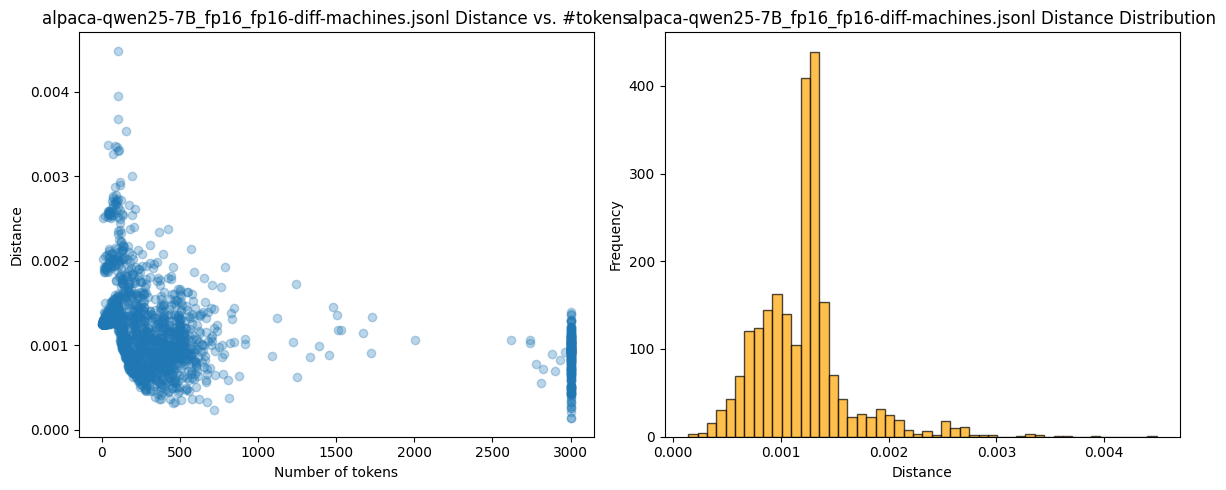

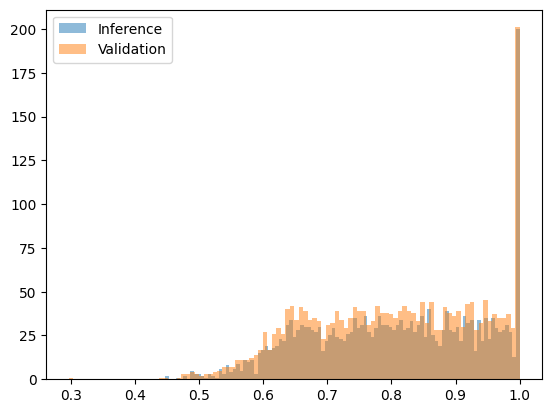


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 2300
Min:   0.0001
Max:   0.0045
Mean:  0.0012
Std:   0.0004
Quartiles:
0.25    0.000928
0.50    0.001248
0.75    0.001330
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 2300
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0012, sigma=0.0004
KS test: statistic=0.1544, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=8.2657, loc=0.0000, scale=0.0001
KS test: statistic=0.1388, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.3603, loc=0.0000, scale=0.0011
KS test: statistic=0.1584, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=8.2556, beta=6863.7016, loc=0.0000, scale=1.0000
KS test: statistic=0.1387, p-value=0.0000
##################################################################

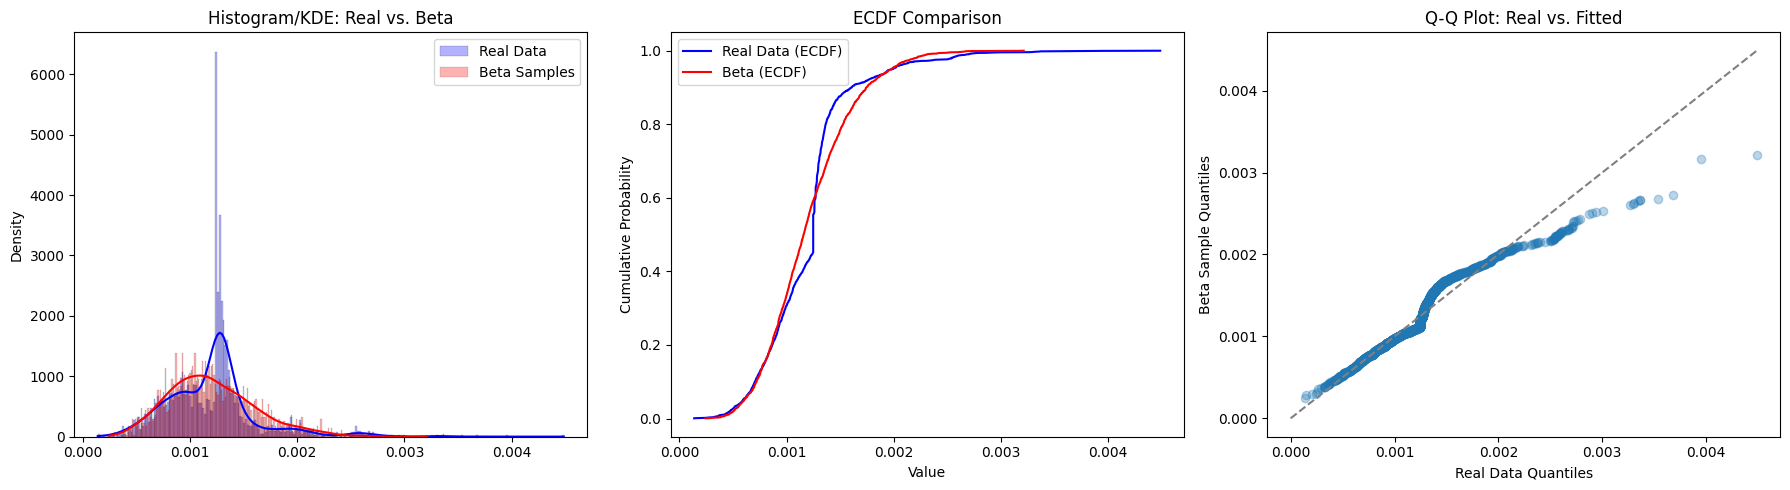




################################################################################
Analyzing Alpaca-fp8-fp8-same3090 : alpaca-qwen25-7B_fp8_fp8-same3090.jsonl
Dropped 0 / 1100 items


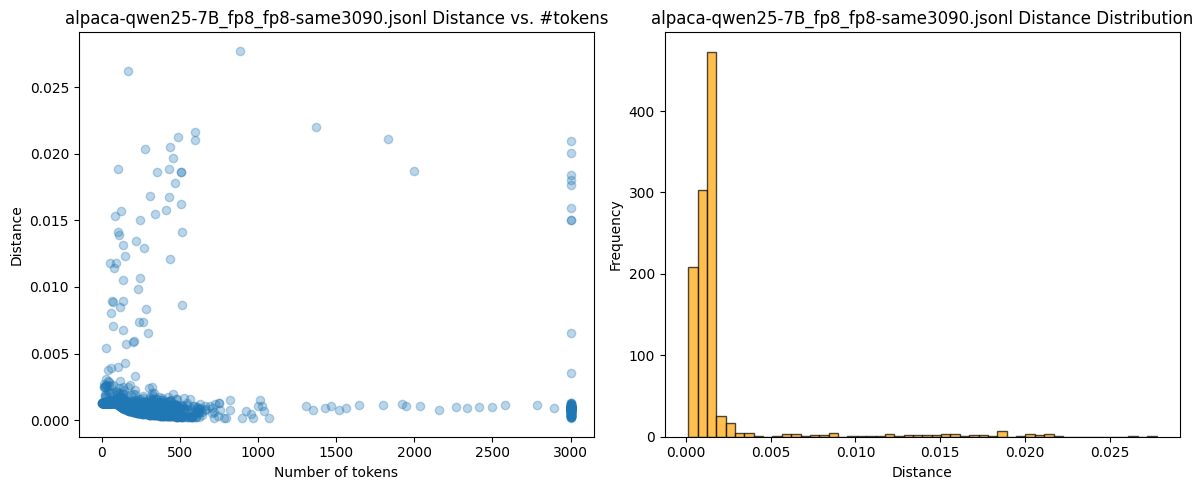

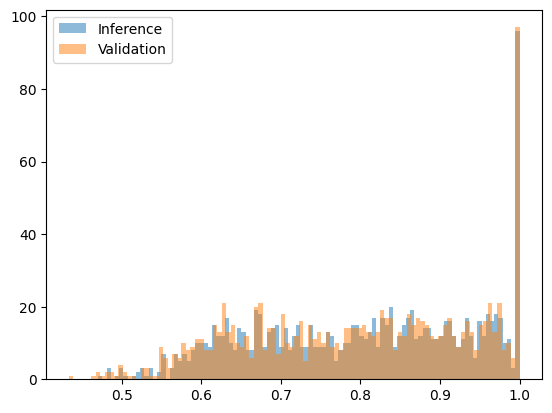


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 1100
Min:   0.0001
Max:   0.0278
Mean:  0.0019
Std:   0.0034
Quartiles:
0.25    0.000796
0.50    0.001248
0.75    0.001295
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 1100
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0019, sigma=0.0034
KS test: statistic=0.4130, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=1.1248, loc=0.0000, scale=0.0016
KS test: statistic=0.3228, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.8106, loc=0.0000, scale=0.0011
KS test: statistic=0.2236, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=1.1185, beta=601.4494, loc=0.0000, scale=1.0000
KS test: statistic=0.3234, p-value=0.0000
###################################################################

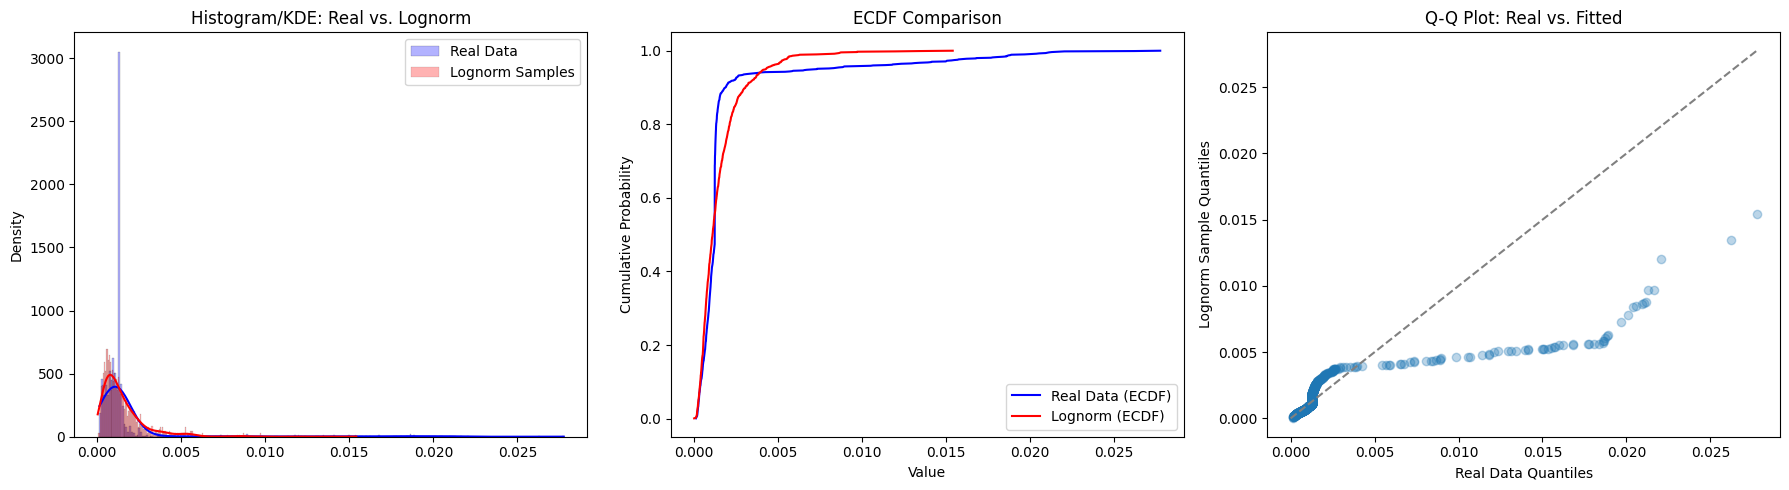




################################################################################
Analyzing Alpaca-fp8-fp8-sameL40 : alpaca-qwen25-7B_fp8_fp8-sameL40.jsonl
Dropped 0 / 500 items


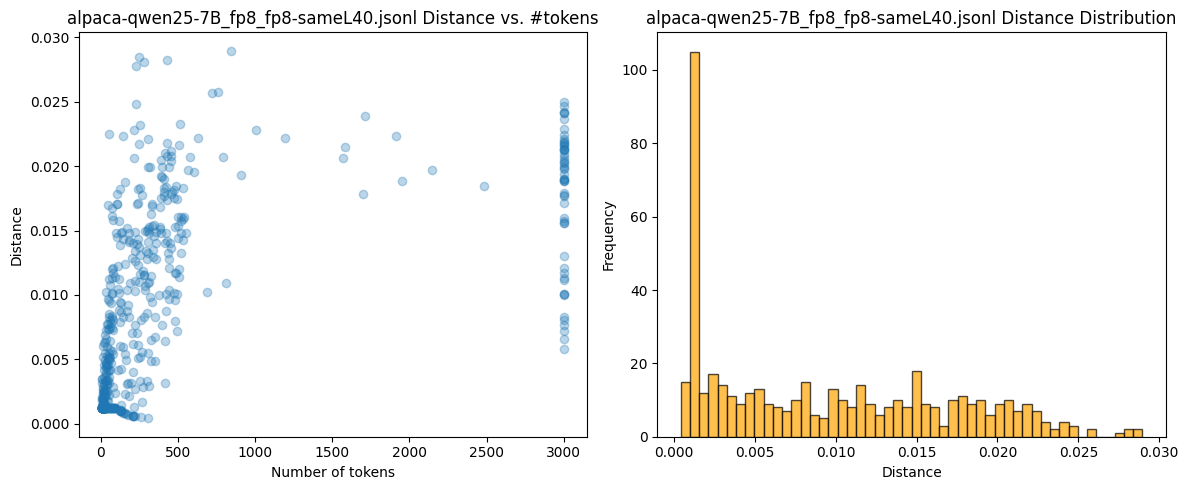

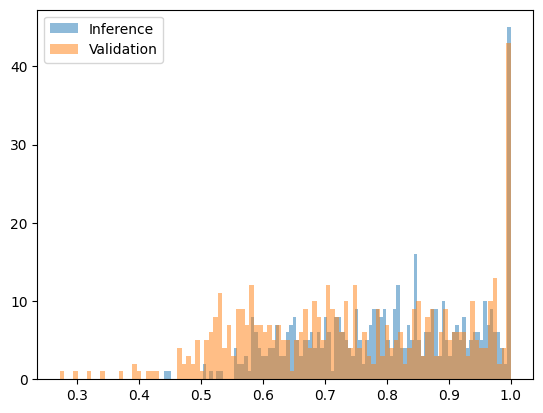


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 500
Min:   0.0004
Max:   0.0290
Mean:  0.0095
Std:   0.0075
Quartiles:
0.25    0.001813
0.50    0.008218
0.75    0.015386
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 500
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0095, sigma=0.0075
KS test: statistic=0.1291, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=1.1840, loc=0.0000, scale=0.0080
KS test: statistic=0.1268, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=1.1091, loc=0.0000, scale=0.0059
KS test: statistic=0.1388, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=1.1773, beta=123.0164, loc=0.0000, scale=1.0000
KS test: statistic=0.1266, p-value=0.0000
#####################################################################

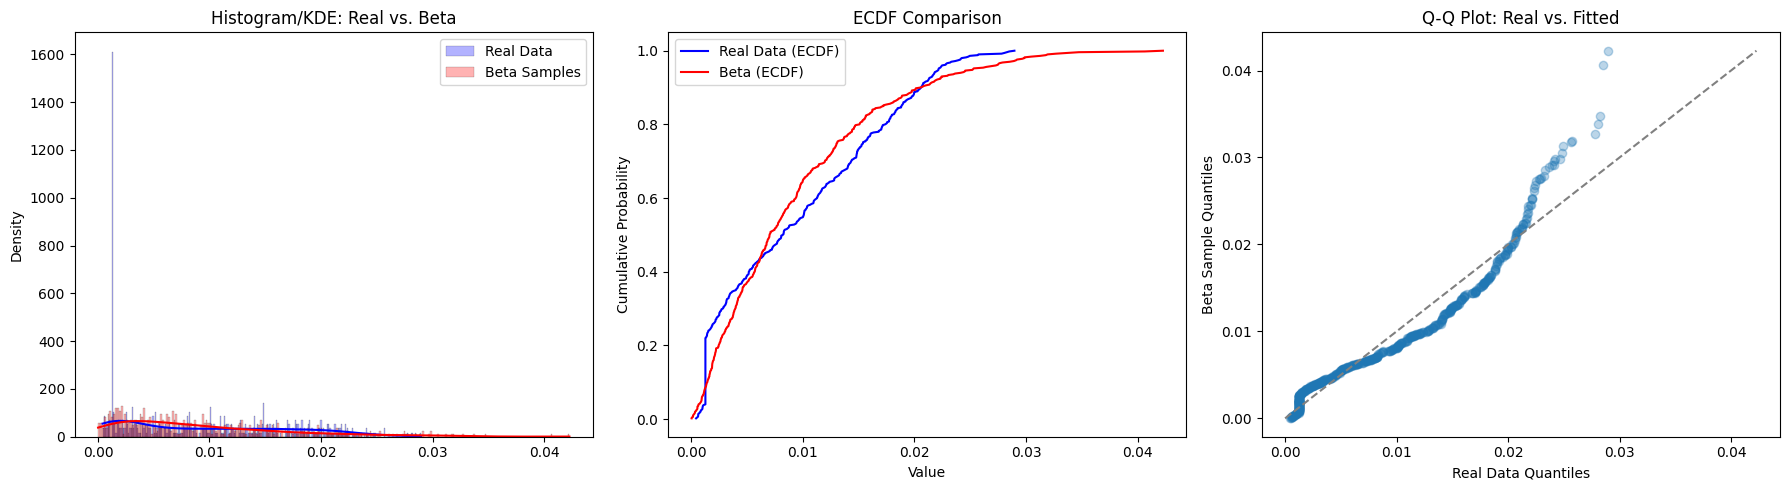




################################################################################
Analyzing Alpaca-w8a16-w8a16-diff-machines : alpaca-qwen25-7B_w8a16_w8a16-diff-machines.jsonl
Dropped 0 / 500 items


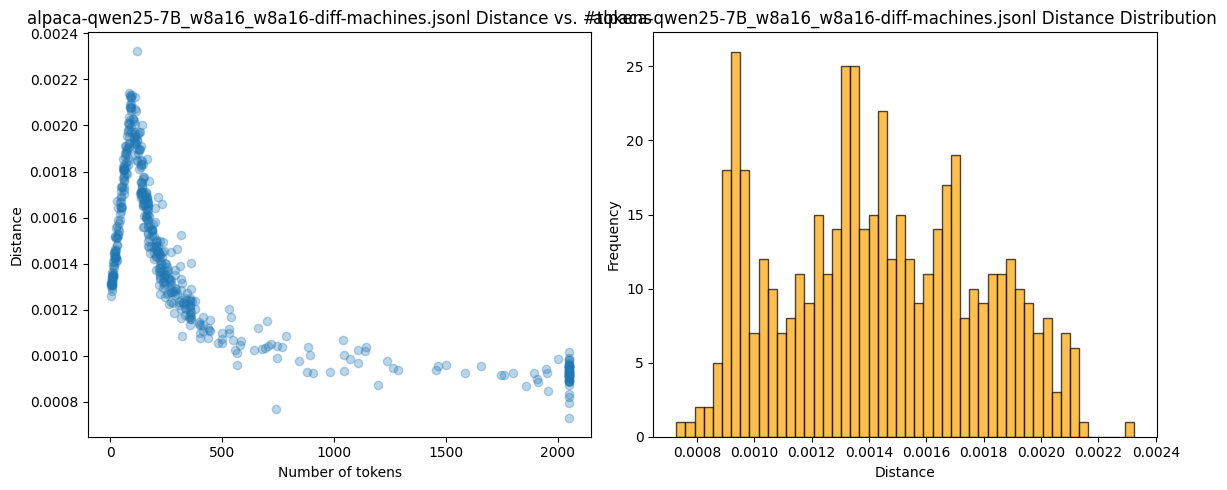

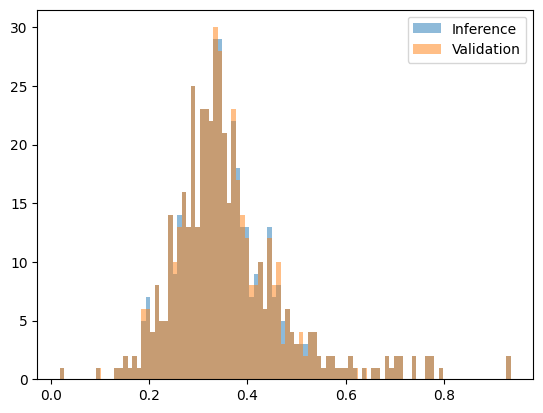


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 500
Min:   0.0007
Max:   0.0023
Mean:  0.0014
Std:   0.0003
Quartiles:
0.25    0.001168
0.50    0.001421
0.75    0.001702
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 500
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0014, sigma=0.0003
KS test: statistic=0.0542, p-value=0.1023
Fitting gamma...
Fitted Gamma Params: shape=16.6031, loc=0.0000, scale=0.0001
KS test: statistic=0.0623, p-value=0.0396
Fitting lognorm...
Fitted Lognormal Params: shape=0.2502, loc=0.0000, scale=0.0014
KS test: statistic=0.0660, p-value=0.0245
Fitting beta...
Fitted Beta Params: alpha=16.5806, beta=11547.8793, loc=0.0000, scale=1.0000
KS test: statistic=0.0623, p-value=0.0397
#################################################################

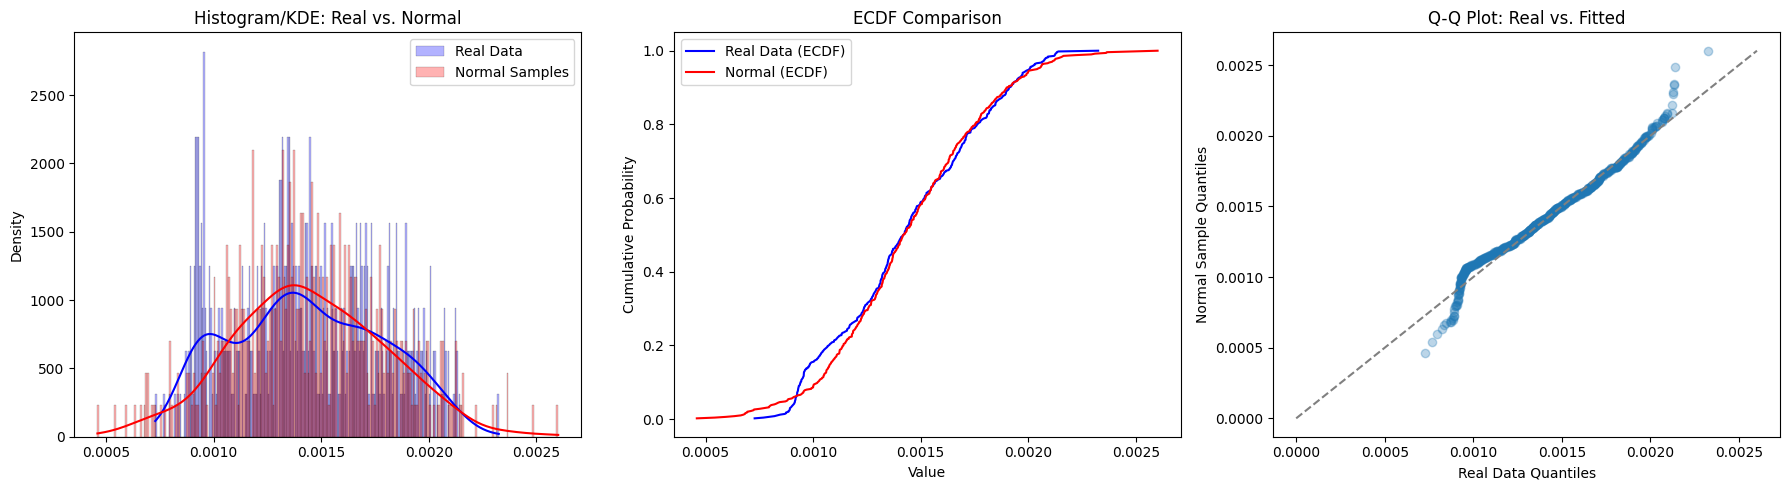




################################################################################
Analyzing Alpaca-w8a8-w8a16-diff-machines : alpaca-qwen25-7B_w8a8_w8a16-diff-machines.jsonl
Dropped 0 / 1400 items


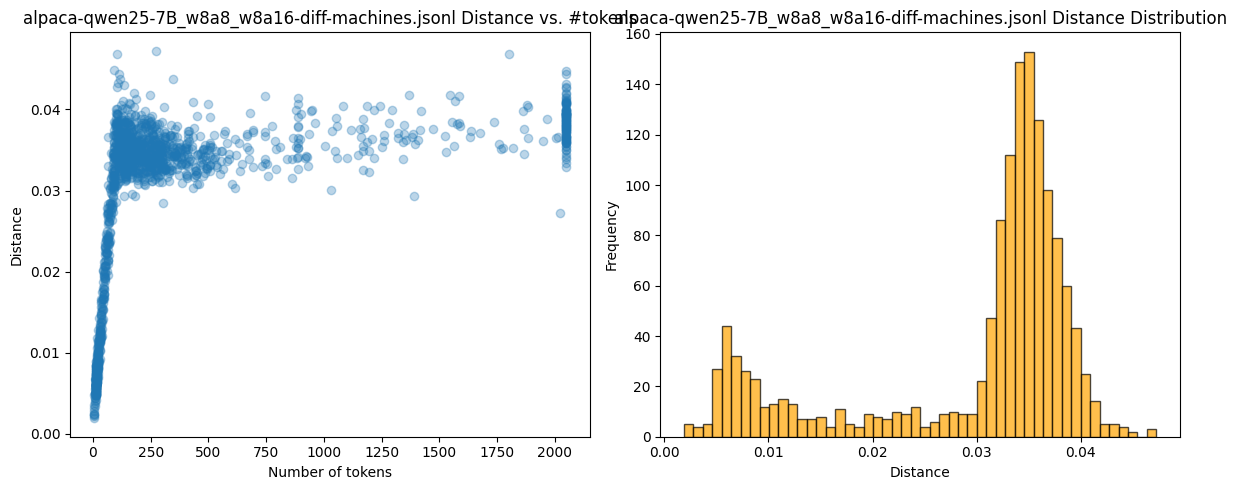

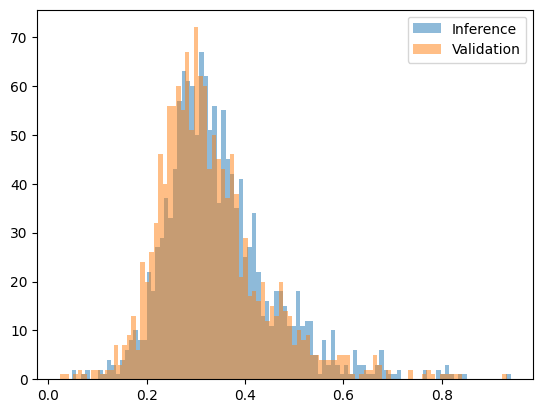


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 1400
Min:   0.0019
Max:   0.0473
Mean:  0.0297
Std:   0.0108
Quartiles:
0.25    0.028298
0.50    0.034085
0.75    0.036269
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 1400
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0297, sigma=0.0108
KS test: statistic=0.2754, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=4.0546, loc=0.0000, scale=0.0073
KS test: statistic=0.3222, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.6044, loc=0.0000, scale=0.0261
KS test: statistic=0.3349, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=3.9944, beta=130.8964, loc=0.0000, scale=1.0000
KS test: statistic=0.3214, p-value=0.0000
###################################################################

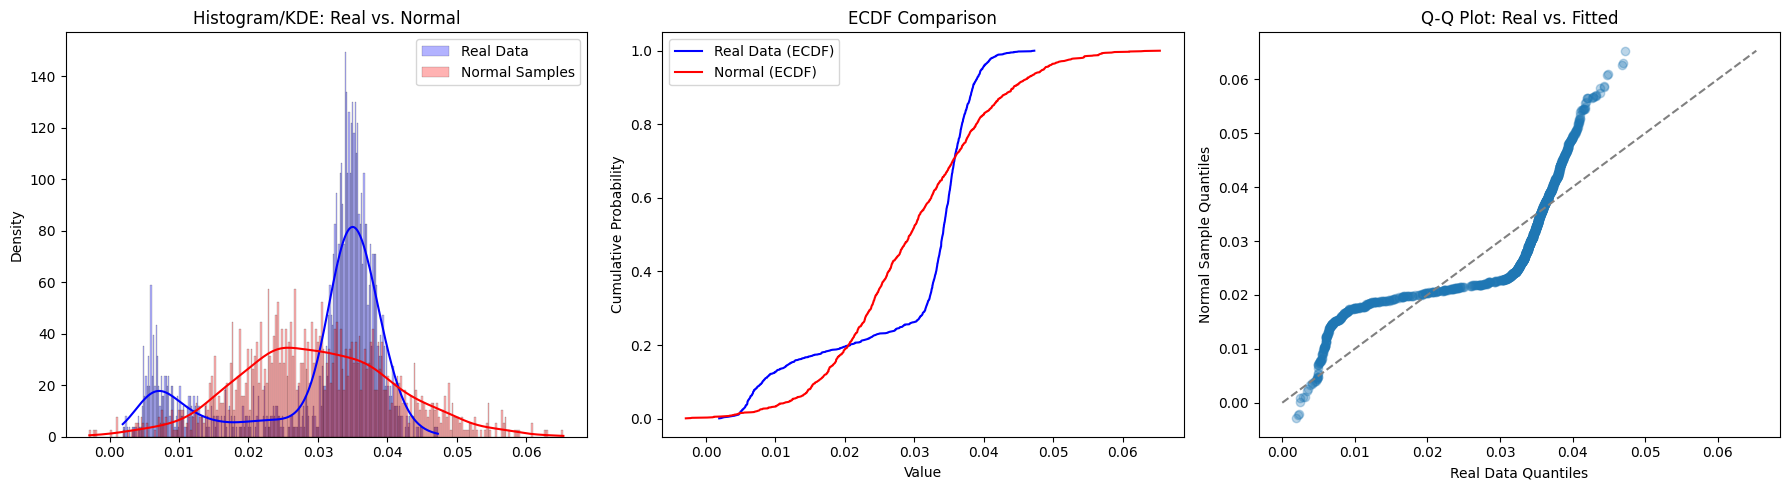




################################################################################
Analyzing Alpaca-w8a8-w8a16-instruct-diff-machines : alpaca-qwen25-7B_w8a8_w8a16-instruct-diff-machines.jsonl
Dropped 0 / 300 items


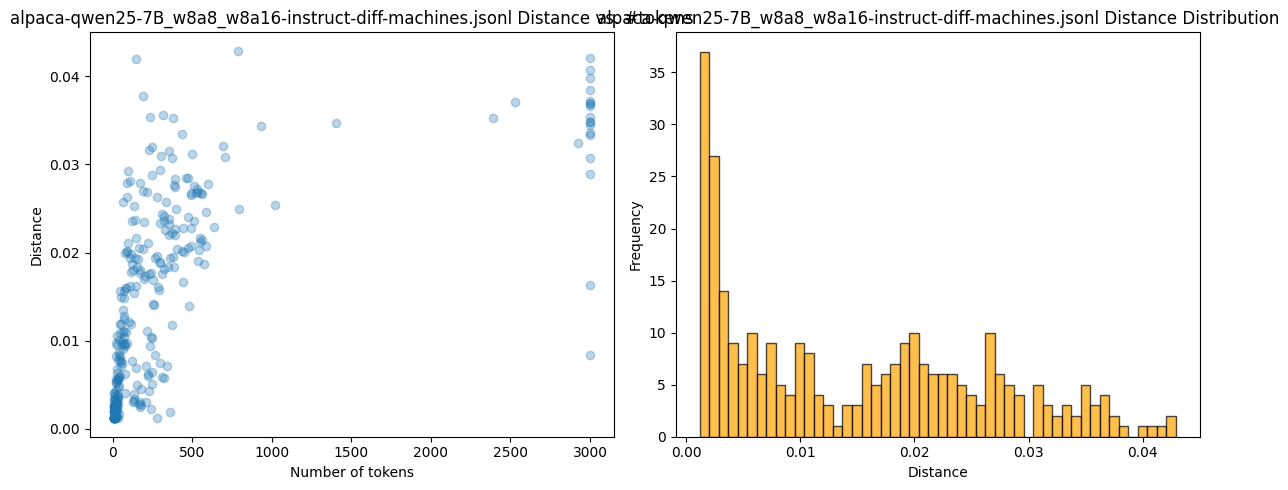

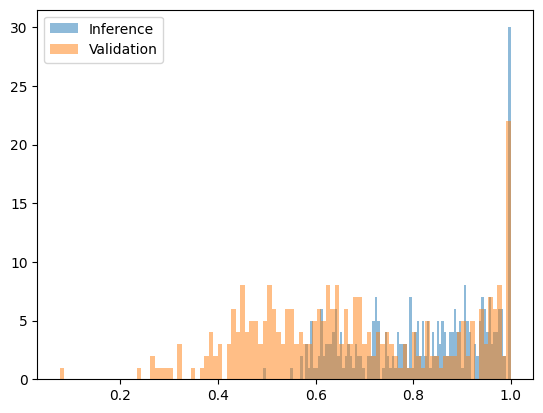


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 300
Min:   0.0012
Max:   0.0429
Mean:  0.0147
Std:   0.0114
Quartiles:
0.25    0.003408
0.50    0.012258
0.75    0.023517
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 300
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0147, sigma=0.0114
KS test: statistic=0.1260, p-value=0.0001
Fitting gamma...
Fitted Gamma Params: shape=1.2414, loc=0.0000, scale=0.0118
KS test: statistic=0.1182, p-value=0.0004
Fitting lognorm...
Fitted Lognormal Params: shape=1.0832, loc=0.0000, scale=0.0093
KS test: statistic=0.1528, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=1.2303, beta=82.5646, loc=0.0000, scale=1.0000
KS test: statistic=0.1172, p-value=0.0005
######################################################################

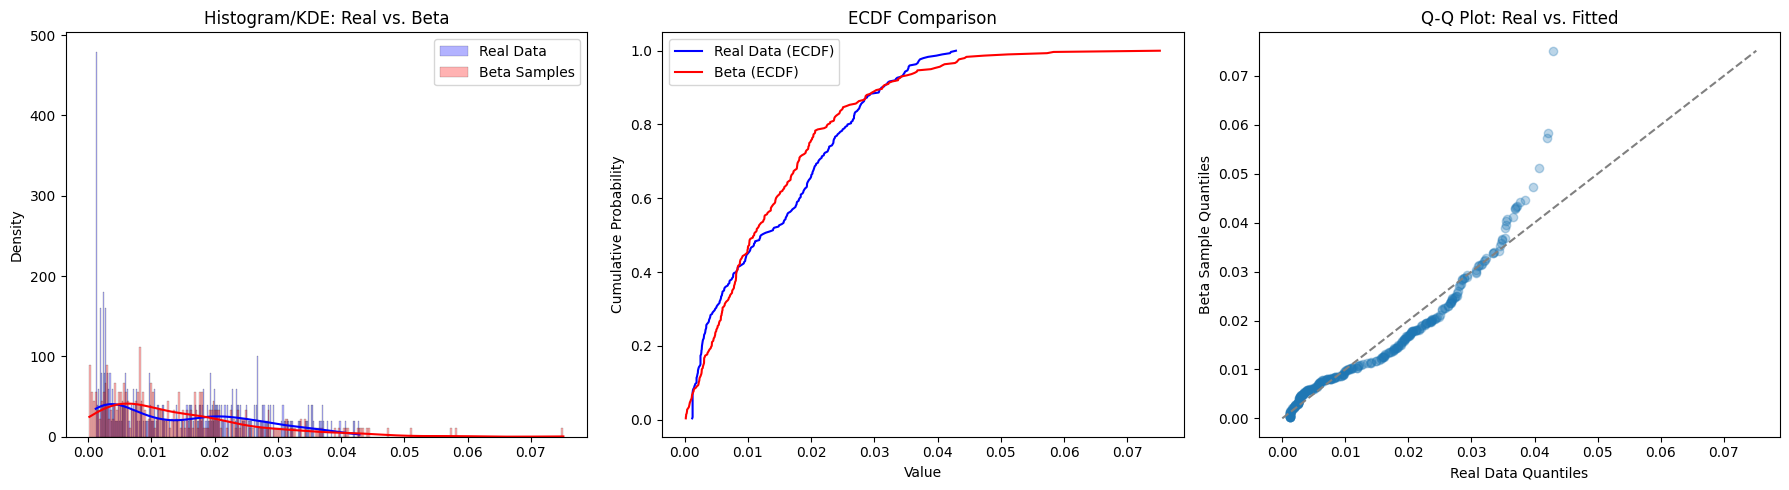




################################################################################
Analyzing Alpaca-w8a8-w8a8-instruct-same-machines-L40 : alpaca-qwen25-7B_w8a8_w8a8-instruct-same-machines.jsonl
Dropped 0 / 700 items


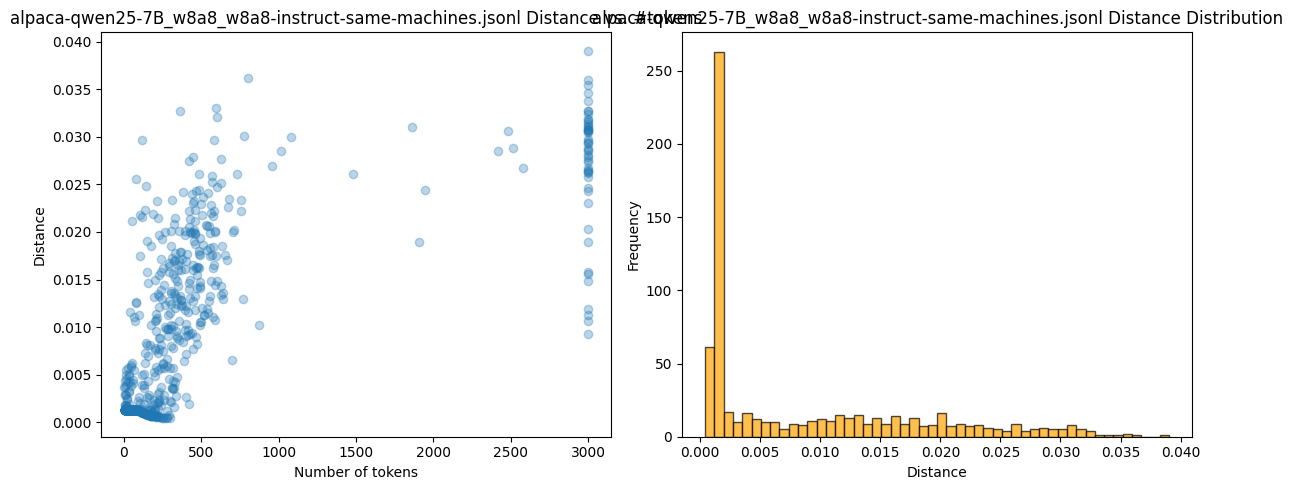

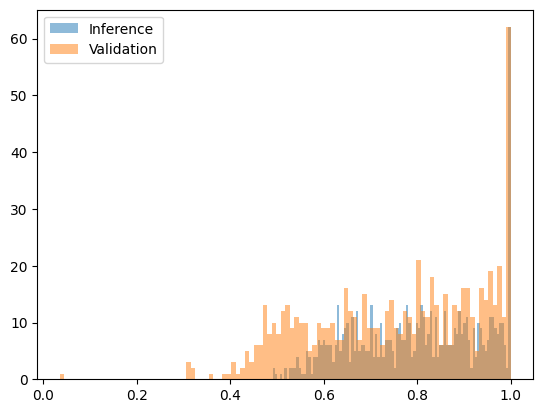


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 700
Min:   0.0004
Max:   0.0390
Mean:  0.0089
Std:   0.0096
Quartiles:
0.25    0.001248
0.50    0.003245
0.75    0.015653
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 700
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0089, sigma=0.0096
KS test: statistic=0.2306, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=0.7891, loc=0.0000, scale=0.0112
KS test: statistic=0.2559, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=1.3059, loc=0.0000, scale=0.0042
KS test: statistic=0.2588, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=0.7843, beta=87.8346, loc=0.0000, scale=1.0000
KS test: statistic=0.2558, p-value=0.0000
######################################################################

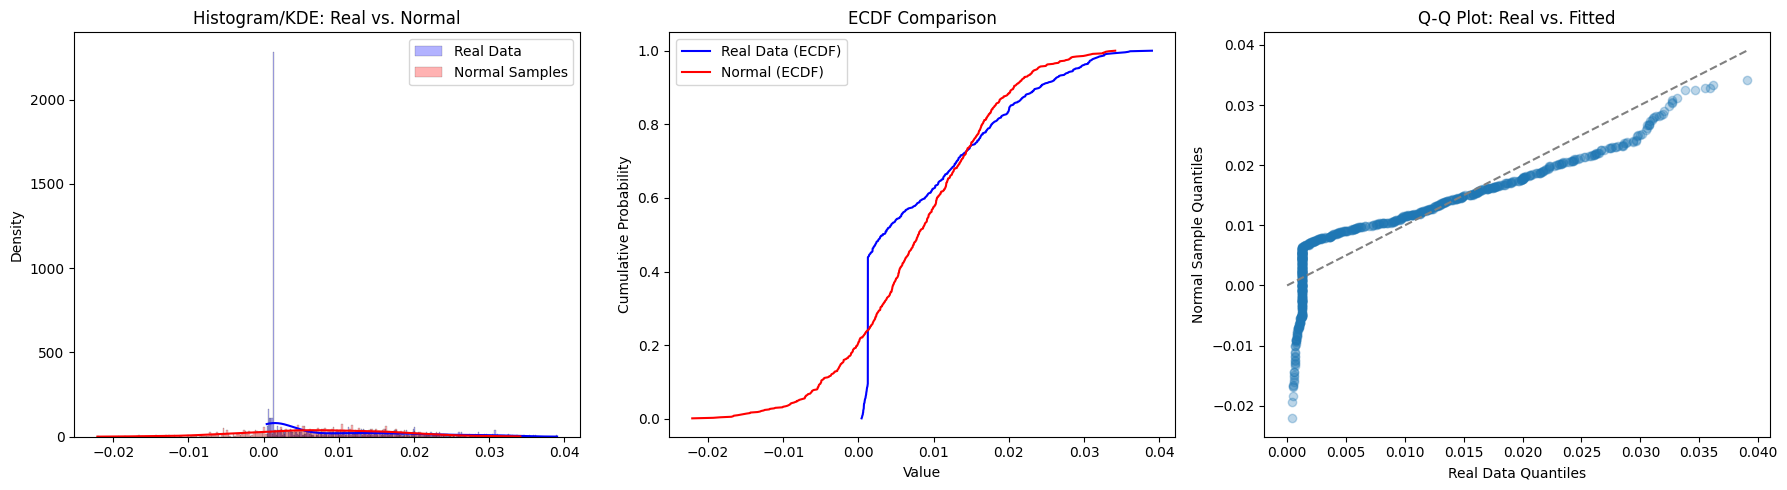




################################################################################
Analyzing Alpaca-w8a16-w8a16-vs-7b-w8a16 : alpaca-qwen25-3b-w8a16-vs-7b-w8a16.jsonl
Dropped 0 / 3000 items


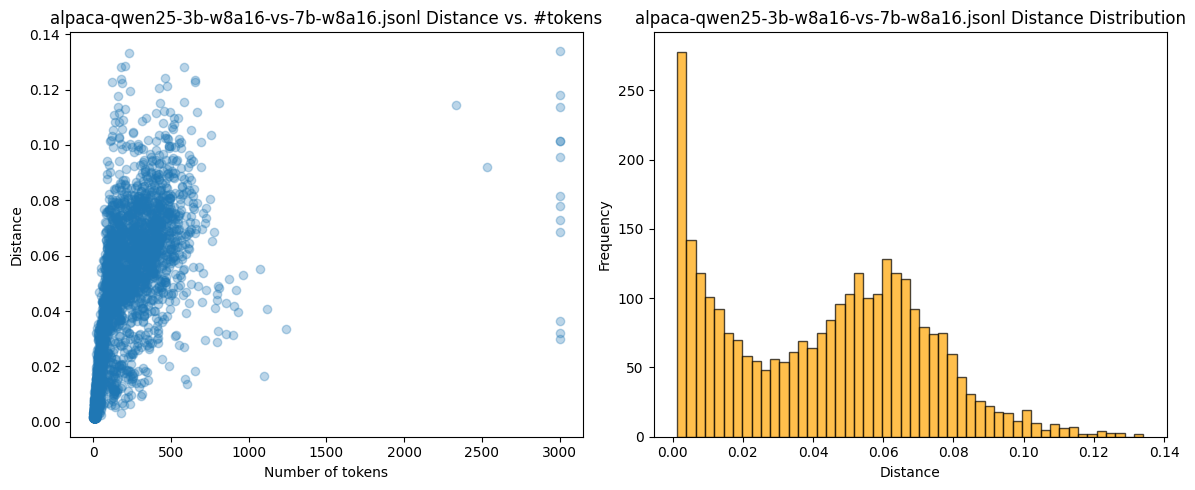

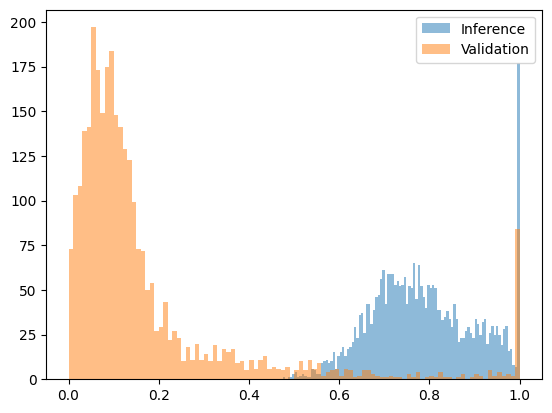


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 3000
Min:   0.0012
Max:   0.1340
Mean:  0.0432
Std:   0.0285
Quartiles:
0.25    0.015262
0.50    0.046364
0.75    0.064697
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 3000
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0432, sigma=0.0285
KS test: statistic=0.0902, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=1.3483, loc=0.0000, scale=0.0321
KS test: statistic=0.1492, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=1.1297, loc=0.0000, scale=0.0286
KS test: statistic=0.1811, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=1.3198, beta=29.4126, loc=0.0000, scale=1.0000
KS test: statistic=0.1461, p-value=0.0000
####################################################################

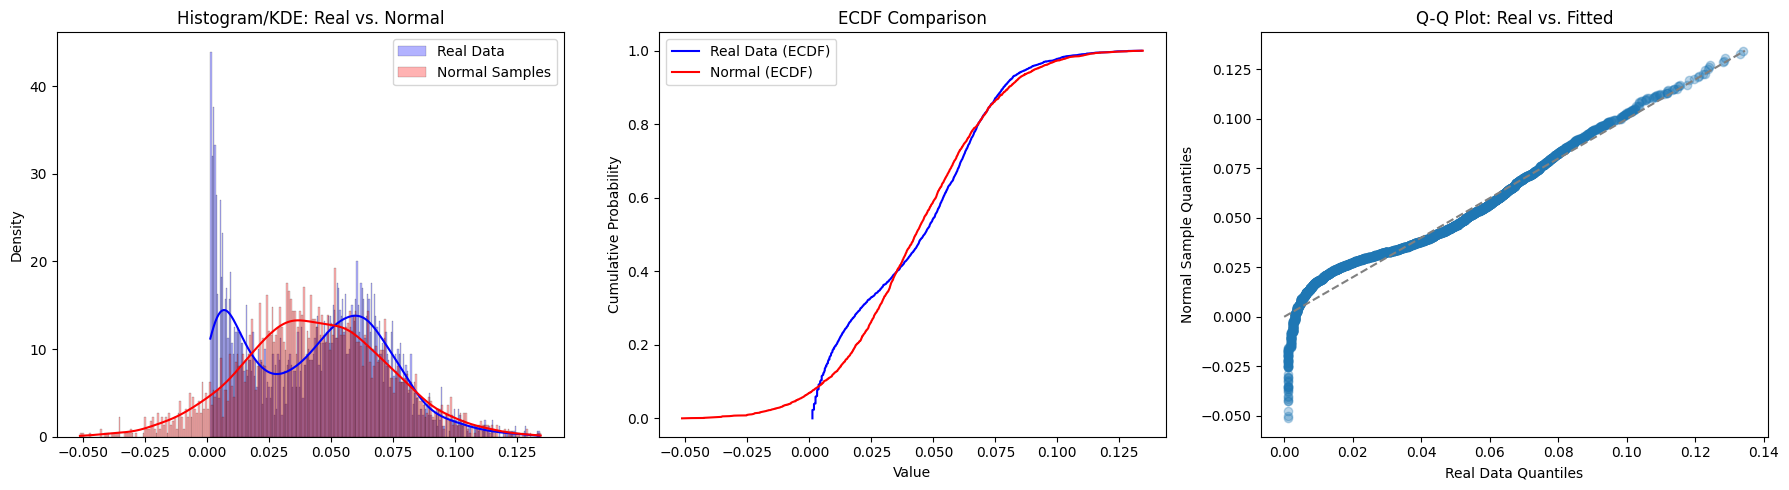




################################################################################
Analyzing Alpaca-w8a16-vs-w8a16-same-3090 : alpaca-qwen25-w8a16-vs-w8a16-same-3090.jsonl
Dropped 0 / 1000 items


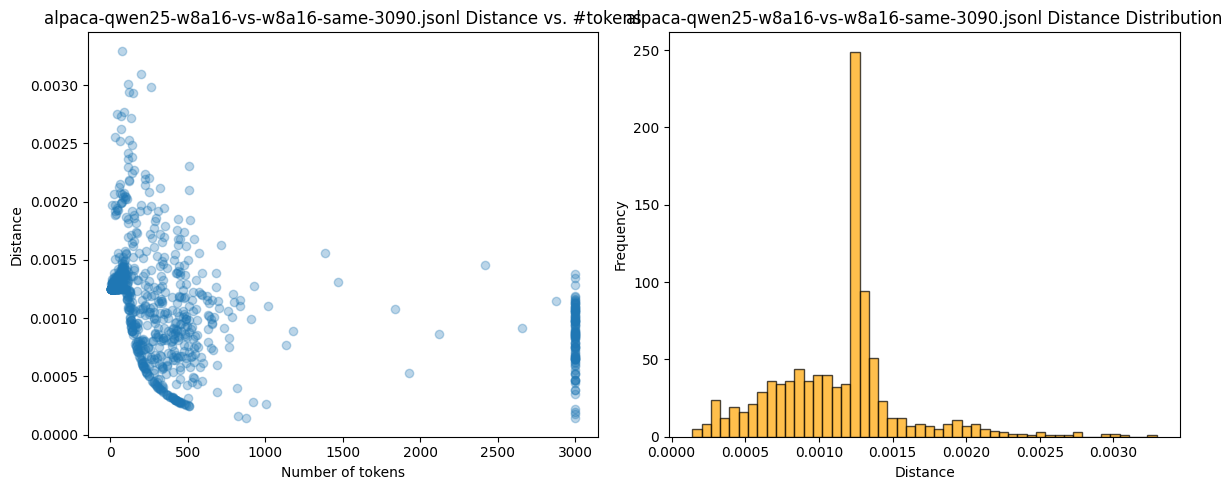

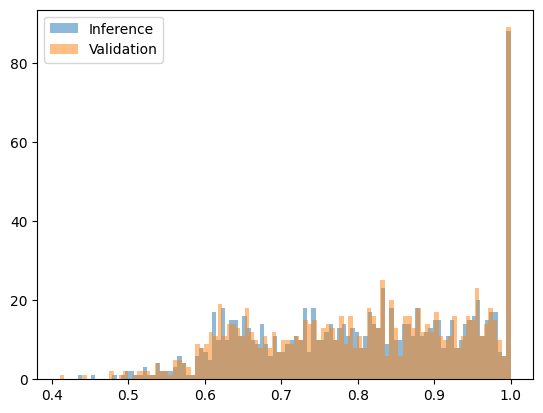


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 1000
Min:   0.0001
Max:   0.0033
Mean:  0.0011
Std:   0.0004
Quartiles:
0.25    0.000849
0.50    0.001248
0.75    0.001294
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 1000
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0011, sigma=0.0004
KS test: statistic=0.1368, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=5.7021, loc=0.0000, scale=0.0002
KS test: statistic=0.1687, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.4586, loc=0.0000, scale=0.0010
KS test: statistic=0.1812, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=5.6967, beta=5020.5352, loc=0.0000, scale=1.0000
KS test: statistic=0.1686, p-value=0.0000
##################################################################

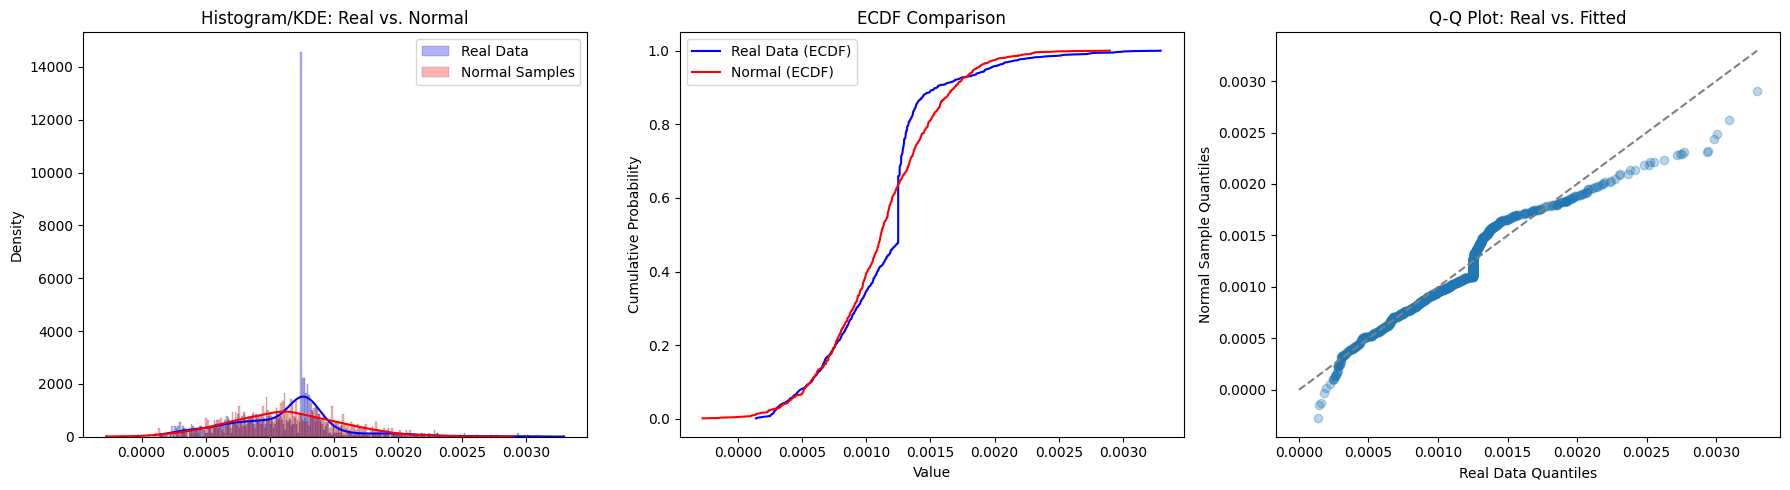




################################################################################
Analyzing Alpaca-w8a16-vs-w8a16-same-l40 : alpaca-qwen25-w8a16-vs-w8a16-same-l40.jsonl
Dropped 0 / 1000 items


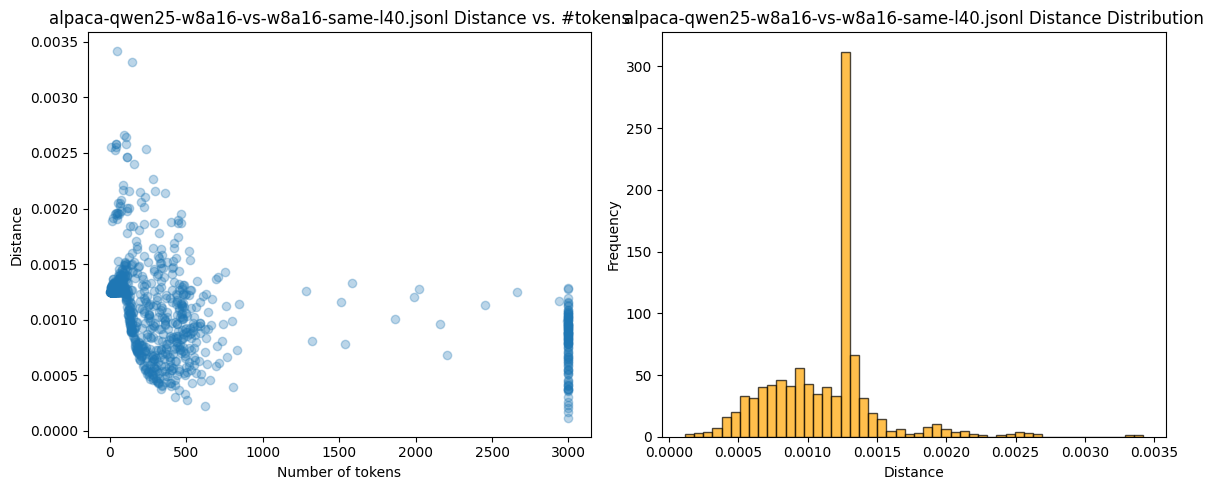

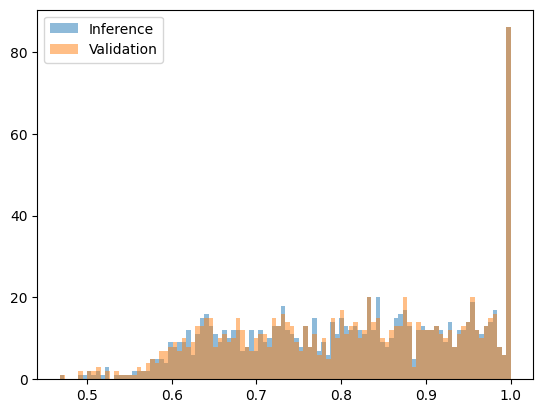


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 1000
Min:   0.0001
Max:   0.0034
Mean:  0.0011
Std:   0.0004
Quartiles:
0.25    0.000854
0.50    0.001248
0.75    0.001275
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 1000
Min:   1.0000
Max:   1.0000
Mean:  1.0000
Std:   0.0000
Quartiles:
0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0011, sigma=0.0004
KS test: statistic=0.1389, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=7.5559, loc=0.0000, scale=0.0001
KS test: statistic=0.1748, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.3886, loc=0.0000, scale=0.0010
KS test: statistic=0.1850, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=7.5483, beta=6754.5684, loc=0.0000, scale=1.0000
KS test: statistic=0.1748, p-value=0.0000
##################################################################

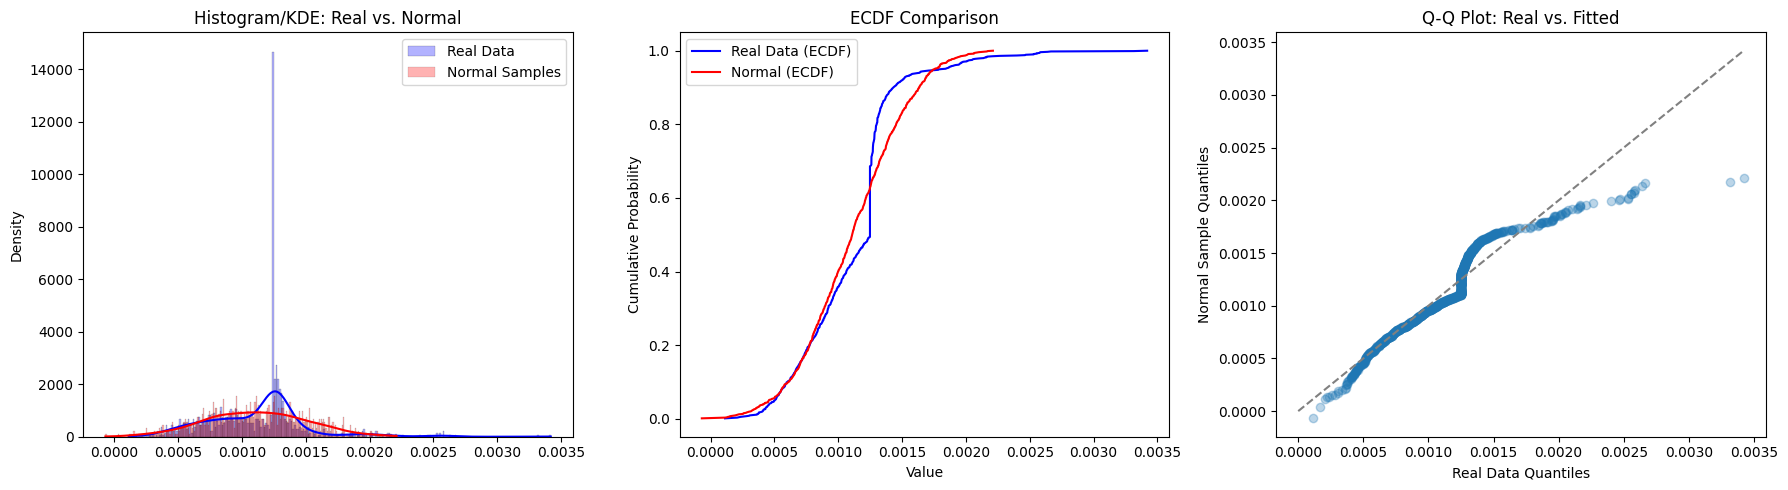

In [52]:
data_path_to_fit = {}
data_path_to_distances = {}

for name, data_path in DATA_PATHS.items():
    print("\n\n")
    print(80*"#")
    print(f"Analyzing {name} : {data_path}")
    items = load_from_jsonl(data_path, n=100000)
    # items = [item for item in items if len(item.inference_result.results) > 1000]
    items, distances, top_k_matches_ratios = process_data(items)
    plot_distances_and_matches(items, distances, top_k_matches_ratios, data_path)
    plot_probability_distribution(items)
    best_fit, fit_results = analyze(distances, top_k_matches_ratios)
    data_path_to_fit[data_path] = best_fit
    data_path_to_distances[data_path] = distances
    

In [53]:
from validation.utils import token_distance2

In [54]:
same_machine_l40 = load_from_jsonl('alpaca-qwen25-7B_w8a8_w8a8-instruct-same-machines.jsonl', n=100)

In [55]:
items_sorted = sorted(
    same_machine_l40,
    key=lambda x: distance2(x.inference_result, x.validation_result),
    reverse=True
)

for item in items_sorted[:10]:
    print(80*"#")
    print(item.prompt)
    print("Distance:", distance2(item.inference_result, item.validation_result))
    print(item.inference_result.text)
    for p1, p2 in zip(item.inference_result.results, item.validation_result.results):
        print(f"   Token distance {tokenizer.decode([int(p1.token)])}: {token_distance2(p1, p2)}")
        for t in p1.logprobs:
            print(f"       {t}: {p1.logprobs[t]} {p2.logprobs[t]}")
    break

################################################################################
Write a short story in third person narration about a protagonist who has to make an important career decision.
Distance: (0.036143016728015225, 1.0)
In the quaint town of Willowbrook, nestled between rolling hills and dense forests, lived Emily Carter, a talented but uncertain young woman working as a junior editor at the local newspaper. For years, she had dreamed of making her mark on literature—perhaps even becoming a novelist herself—but each day spent pouring over articles for print seemed to push that dream further away.

One crisp autumn evening, while walking home from work under a canopy of golden leaves, Emily stumbled upon a small bookstore tucked behind a row of oak trees. The shop was dimly lit by warm, yellow lights emanating through its windows, drawing her inside like a moth. Inside, rows of books lined every surface: towering shelves stretching up into shadows filled with titles ranging f